# Growth mixture models

Note: the numerical results for this analysis have changed a bit when going from `distrax` to `numpyro`. For the exact results as in the 'An introduction to Sequential Monte Carlo for Bayesian inference and model comparison — with examples for psychology and behavioral science' paper, please see [the examples here](https://github.com/UncertaintyInComplexSystems/Introduction-to-SMC) that are implemented with `bamojax` v0.2.0.

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [3]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  

import jax.random as jrnd
import jax.numpy as jnp
import blackjax
from blackjax import normal_random_walk, nuts
from blackjax.diagnostics import effective_sample_size

import pandas as pd
import jax.scipy.special as jsp

import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb

import time

import bamojax
from bamojax.base import Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import MCMCInference, SMCInference

print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Numpyro version:      ', npr.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Jax version:           0.7.2
BlackJax version:      1.2.5
Numpyro version:       0.19.0
BaMoJax version:       0.2.0+30.g04b1050.dirty
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


Evaluation and utility functions

In [4]:
from jax.scipy.stats import gaussian_kde

def quantify_multimodality_divergence(samples, varname, vardim, support):
    def KL_MC(p, q, supp, epsilon=1e-8):
        px = p(supp) + epsilon
        qx = q(supp) + epsilon  
        return 1 / len(px) * jnp.sum(px*(jnp.log(px) - jnp.log(qx)))

    #
    m = 1000
    varsupport = jnp.linspace(*support, num=m)
    kl_scores = []
    for k1 in range(K):        
        p = gaussian_kde(samples[varname][:, k1, vardim].flatten())
        for k2 in range(k1+1, K):
            q = gaussian_kde(samples[varname][:, k2, vardim].flatten())
            kl_score = KL_MC(p, q, varsupport)
            kl_scores.append(kl_score)
    return kl_scores

#
def multimodality_kl_score(samples, c):
    variable_settings = dict(beta0 = dict(name='beta',
                                        dim=0,
                                        support=[2.2, 3.2]),
                            beta1 = dict(name='beta',
                                        dim=1,
                                        support=[0.0, 1.5]))

    kl_scores_combined = []
    samples_c = select_chain(samples, chain=c)
    for var_settings in variable_settings.values():
        kl_scores = quantify_multimodality_divergence(samples_c, var_settings['name'], var_settings['dim'], var_settings['support'])
        kl_scores_combined.append(kl_scores)
    return jnp.mean(jnp.asarray(kl_scores_combined))

#
def data_fit(model, samples, num_chains=1):
    """ Computes E_p(theta|D) [p(D | theta)]
    
    """
    loglikelihood_fn = model.loglikelihood_fn()
    if num_chains > 1:
        return jnp.mean(jax.vmap(jax.vmap(loglikelihood_fn))(samples), axis=1)
    else:
        return jnp.mean(jax.vmap(loglikelihood_fn)(samples))

#
def centered_softmax(v):
    return jax.nn.softmax(jnp.insert(v, 0, 0, axis=0))

#
def select_chain(samples, chain):
    return jax.tree_util.tree_map(lambda x: x[chain, ...], samples)

#

Plotting functions

In [5]:
def plot_fit(key, Y, smpls, K, degree, color=None, ax=None, title=None):
    if color is None:
        color = 'tab:orange'

    def plot_predictions(key, ax, beta_samples):
        for i in range(0, num_smpls, 5):
            for k in range(K):
                beta = beta_samples[i, k, :]
                mu = jnp.dot(beta, x)
                ax.plot(x[1, :], mu, color=color, alpha=0.01)

        for i in range(T):            
            jitter = 0.005*jrnd.normal(key, shape=(N, ))
            ax.plot(jitter+x[1, i], Y[:, i], '.', color='k', alpha=0.5)

    #
    def decorate_axis(ax):
        ax.set_xlabel('Semester', fontsize=MEDIUM_SIZE)
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([1.0, 4.5])
        ax.set_xticks(jnp.linspace(0, 1, T), jnp.arange(T) + 1, fontsize=SMALL_SIZE)
        ax.tick_params(axis='y', labelsize=SMALL_SIZE)

        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
    
    #

    N, T = Y.shape
    get_polynomial = lambda x, d: x**d
    x = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))

    if jnp.ndim(smpls['beta']) == 4:
        # multiple chains
        num_chains, num_smpls, _, _ = smpls['beta'].shape
    else:    
        num_smpls = smpls['beta'].shape[0]
        num_chains = 1

    if num_chains > 1:
        _, axes = plt.subplots(nrows=1, ncols=num_chains, figsize=(num_chains*6, 3), sharex=True, sharey=True, constrained_layout=True)
        
        for c, ax in enumerate(axes):            
            plot_predictions(key, ax, smpls['beta'][c, ...])
            decorate_axis(ax)
        if title is not None:
            plt.suptitle(title, fontsize=MEDIUM_SIZE)
        axes[0].set_ylabel('GPA', fontsize=MEDIUM_SIZE)
        return axes
    else:
        if ax is None:
            plt.figure(figsize=(8, 4))
            ax = plt.gca()
        if title is not None:
            ax.set_title(title, fontsize=MEDIUM_SIZE)
        plot_predictions(key, ax, smpls['beta'])
        decorate_axis(ax)
        ax.set_ylabel('GPA', fontsize=MEDIUM_SIZE)
        return ax

#
def plot_posterior(smpls, K, degree, title=None):
    if title == None:
        title = ''
    nbins=40

    _, axes = plt.subplots(nrows=K, ncols=degree+1, constrained_layout=True, figsize=(8, K*2), sharex='col', sharey='col')
    for k in range(K):
        for j in range(degree+1):        
            axes[k, j].hist(smpls['beta'][:, k, j].flatten(), bins=nbins, density=True)
            axes[k, j].set_xlabel(r'$\eta_{{{:s}}}$'.format(f'{k},{j}'), fontsize=SMALL_SIZE)
        axes[k,0].set_ylabel(f'Component {k+1}', fontsize=SMALL_SIZE)
    plt.suptitle(f'Coefficients for different polynomial orders ({title})', fontsize=MEDIUM_SIZE)
    plt.show()

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(smpls['sd'][:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$\sigma_{k+1}$', fontsize=SMALL_SIZE)
    plt.suptitle(f'Observation noise per component ({title})', fontsize=MEDIUM_SIZE)
    plt.show()

    w_raw = smpls['w_raw']
    w = jnp.squeeze(jax.vmap(centered_softmax, in_axes=0)(w_raw))

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(w[:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$w_{k+1}$', fontsize=SMALL_SIZE)
    plt.suptitle(f'Component weight ({title})', fontsize=MEDIUM_SIZE)
    plt.show()

#

Load data

In [8]:
url = 'https://jasp-stats.org/wp-content/uploads/2022/02/gpa.csv'
storage_options = {'User-Agent': 'Mozilla/5.0'}
df = pd.read_csv(url, storage_options=storage_options)

Y = df[['gpa1', 'gpa2', 'gpa3', 'gpa4', 'gpa5', 'gpa6']].to_numpy()
N, T = Y.shape

degree = 1

get_polynomial = lambda x, d: x**d
X = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))

Construct Growth Mixture Model using BaMoJax

In [ ]:
def grmm_link_fn(w_raw, beta, sd, x):
    mu = jnp.dot(beta, x)
    T = mu.shape[1]
    probs = centered_softmax(w_raw).T
    mixture_dist = dist.Categorical(probs=probs)
    sd = jnp.eye(T) * sd[:, None, None]
    component_dist = dist.MultivariateNormal(loc=mu, covariance_matrix=sd)
    return dict(mixing_distribution=mixture_dist,
                component_distribution=component_dist)

#
def make_grmm(X, Y, degree, K):
    GrMM = Model('Growth mixture model')
    w_node = GrMM.add_node('w_raw', distribution=dist.Normal(loc=0.0, scale=1.0), shape=(K-1, ))
    beta_node = GrMM.add_node('beta', distribution=dist.Normal(loc=0.0, scale=2.0), shape=(K, degree + 1))
    sd_node = GrMM.add_node('sd', distribution=dist.TransformedDistribution(dist.Normal(loc=0.0, scale=1.0), nprb.ExpTransform()), shape=(K, ))
    x_node = GrMM.add_node('X', observations=X)
    y_node = GrMM.add_node('Y', 
                        observations=Y, 
                        distribution=dist.MixtureSameFamily,
                        link_fn=grmm_link_fn,
                        parents=dict(w_raw=w_node, beta=beta_node, sd=sd_node, x=x_node))
    return GrMM

#

K = 4
GrMM = make_grmm(X, Y, degree=degree, K=K)
GrMM.print_gibbs()

Gibbs structure:
w_raw               : p(Y | X, beta, w_raw, sd) p(w_raw)
beta                : p(Y | X, beta, w_raw, sd) p(beta)
sd                  : p(Y | X, beta, w_raw, sd) p(sd)


In [12]:
num_particles = 2000

Set up MCMC kernels

In [70]:
# Metropolis-Hastings

rmh_params = dict(sigma=0.01*jnp.eye(GrMM.get_model_size()))
rmh = mcmc_sampler(GrMM, mcmc_kernel=normal_random_walk, mcmc_parameters=rmh_params)

# Gibbs

step_fns = dict(beta=normal_random_walk, 
                w_raw=normal_random_walk,
                sd=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.1*jnp.eye(K*(degree+1))), 
                      w_raw=dict(sigma=0.1*jnp.eye(K-1)), 
                      sd=dict(sigma=0.1*jnp.eye(K)))

gibbs = gibbs_sampler(GrMM, step_fns=step_fns, step_fn_params=step_fn_params)

# NUTS HMC; warmup takes about 30 seconds

start_warmup = time.time()
key = jrnd.PRNGKey(42)
key, k_init, k_warmup = jrnd.split(key, 3)
num_warmup = 500
logdensity_fn = lambda state: GrMM.loglikelihood_fn()(state) + GrMM.logprior_fn()(state)
warmup = blackjax.window_adaptation(nuts, logdensity_fn)
(_, warm_parameters), _ = warmup.run(k_warmup, GrMM.sample_prior(k_init), num_steps=num_warmup)  
stop_warmup = time.time()
warmup_time = stop_warmup - start_warmup
nuts_sampler = mcmc_sampler(GrMM, mcmc_kernel=nuts, mcmc_parameters=warm_parameters)

Run MCMC until convergence for different MCMC kernels:

In [76]:
%%time
key = jrnd.PRNGKey(12345)
num_chains = 4

kernels = {}
kernels['MH'] = dict(kernel=rmh, num_samples=[2_000_000]) 
kernels['Gibbs'] = dict(kernel=gibbs, num_samples=[1_250_000])  
kernels['NUTS'] = dict(kernel=nuts_sampler, num_samples=[20_000])  

mcmc_results = {}

for name, settings in kernels.items():
    mcmc_results[name] = []
    for num_samples in settings['num_samples']:
        key, subkey = jrnd.split(key)
        start = time.time()
        num_burn = num_samples
        num_thin = int(num_samples / num_particles)  # ensure MCMC and SMC have the same number of samples of the posterior
        kernel = settings['kernel']
        engine = MCMCInference(model=GrMM, num_chains=num_chains, num_samples=num_samples, num_burn=num_burn, num_thin=num_thin, mcmc_kernel=kernel)
        result = engine.run(subkey)
        samples = result['states']
        stop = time.time()
        elapsed = stop - start
        result_dict = {}
        result_dict['samples'] = samples
        result_dict['time_elapsed'] = elapsed
        mcmc_results[name].append(result_dict)
        fit = data_fit(GrMM, samples, num_chains)
        if num_chains > 1:
            print(f'{name}: Log-likelihood for {num_samples} steps (done in {elapsed:0.2f} seconds): {jnp.mean(fit):0.3f} (SD: {jnp.std(fit):0.3f})')
        else:
            print(f'{name}: Log-likelihood for {num_samples} steps (done in {elapsed:0.2f} seconds): {fit:0.3f}')

mcmc_results_file = '/home/maxhin/Documents/Code/SMC tutorial/GMM/review1/GrMM/mcmc_results.npy'

jnp.save(mcmc_results_file, mcmc_results)

MH: Log-likelihood for 2000000 steps (done in 700.91 seconds): -171.904 (SD: 12.320)
Gibbs: Log-likelihood for 1250000 steps (done in 952.05 seconds): -156.943 (SD: 0.697)
NUTS: Log-likelihood for 20000 steps (done in 428.99 seconds): -228.303 (SD: 124.360)
CPU times: user 28min 3s, sys: 6min 47s, total: 34min 50s
Wall time: 34min 46s


In [8]:
mcmc_results_file = '/home/maxhin/Documents/Code/SMC tutorial/GMM/review1/GrMM/mcmc_results.npy'

mcmc_results = jnp.load(mcmc_results_file, allow_pickle=True).item()

Note: the Gibbs sampler seems a bit inconsistent in how low it takes to converge; sometimes one of the chains is doing something different.

Similarly run SMC until convergence for different mutation kernels and number of mutation steps

In [80]:
%%time
key = jrnd.PRNGKey(42) 
num_chains = 4


kernels = {}
# kernels['MH-in-SMC'] = dict(kernel=rmh, num_steps=[100, 200, 300, 400, 500, 600, 700, 800])
# kernels['Gibbs-in-SMC'] = dict(kernel=gibbs, num_steps=[10, 20, 30, 40, 50])
# kernels['NUTS-in-SMC'] = dict(kernel=nuts_sampler, num_steps=[1, 2, 5])

# At these final values the log-likelihood is approximately -156, which seems near the optimum when looking at the NUTS results

kernels['MH-in-SMC'] = dict(kernel=rmh, num_steps=[800])
kernels['Gibbs-in-SMC'] = dict(kernel=gibbs, num_steps=[50])
kernels['NUTS-in-SMC'] = dict(kernel=nuts_sampler, num_steps=[1])

smc_results = {}

for name, settings in kernels.items():
    smc_results[name] = []
    for num_mcmc_steps in settings['num_steps']:
        key, subkey = jrnd.split(key)
        start = time.time()
        kernel = settings['kernel']
        engine = SMCInference(model=GrMM, num_chains=num_chains, num_particles=num_particles, num_mutations=num_mcmc_steps, mcmc_kernel=kernel)
        result_dict = engine.run(subkey)
        stop = time.time()
        elapsed = stop - start
        smc_results[name].append(result_dict)
        fit = data_fit(GrMM, result_dict['final_state'].particles, num_chains)
        if num_chains > 1:
            print(f'{name}: Log-likelihood for {num_mcmc_steps} mutations (done in {elapsed:0.2f} seconds): {jnp.mean(fit):0.3f} (SD: {jnp.std(fit):0.3f})')
        else:
            print(f'{name}: Log-likelihood for {num_mcmc_steps} mutations (done in {elapsed:0.2f} seconds): {fit:0.3f}')


smc_results_file = '/home/maxhin/Documents/Code/SMC tutorial/GMM/review1/GrMM/smc_results.npy'
jnp.save(smc_results_file, smc_results)

MH-in-SMC: Log-likelihood for 800 mutations (done in 1336.87 seconds): -157.578 (SD: 0.802)
Gibbs-in-SMC: Log-likelihood for 50 mutations (done in 251.19 seconds): -158.499 (SD: 0.704)
NUTS-in-SMC: Log-likelihood for 1 mutations (done in 2132.78 seconds): -157.281 (SD: 0.394)
CPU times: user 52min 24s, sys: 10min 6s, total: 1h 2min 30s
Wall time: 1h 2min 11s


In [11]:
smc_results_file = '/home/maxhin/Documents/Code/SMC tutorial/GMM/review1/GrMM/smc_results.npy'

smc_results = jnp.load(smc_results_file, allow_pickle=True).item()

Visualize posterior fits to verify model has been trained succesfully:

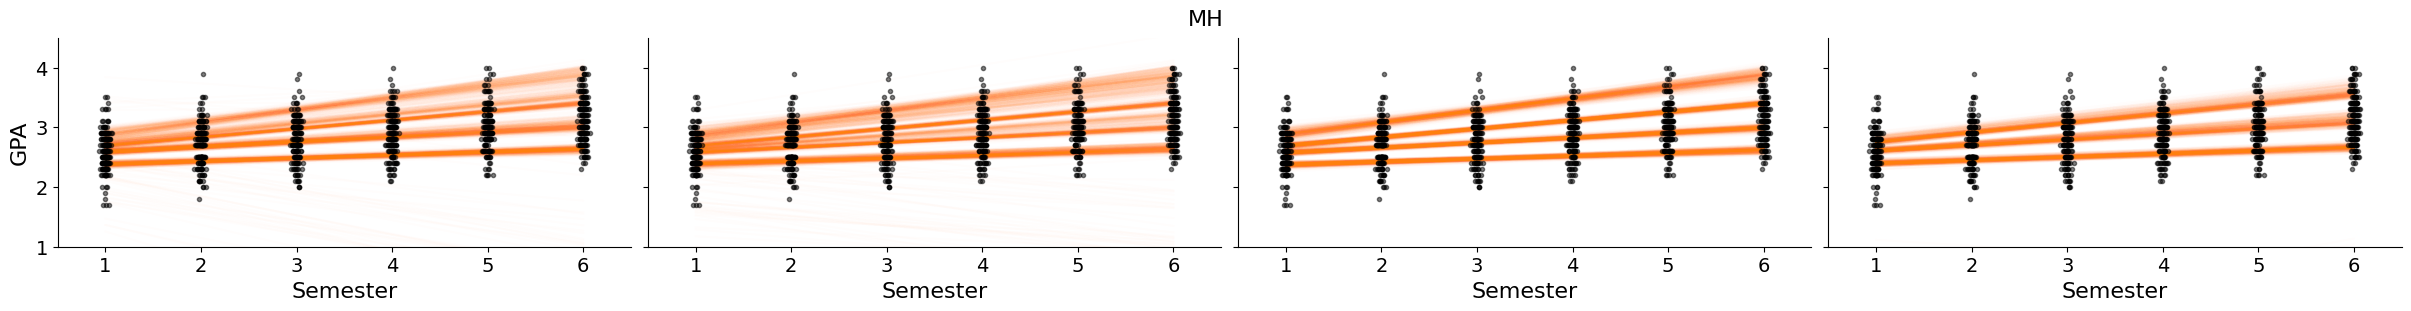

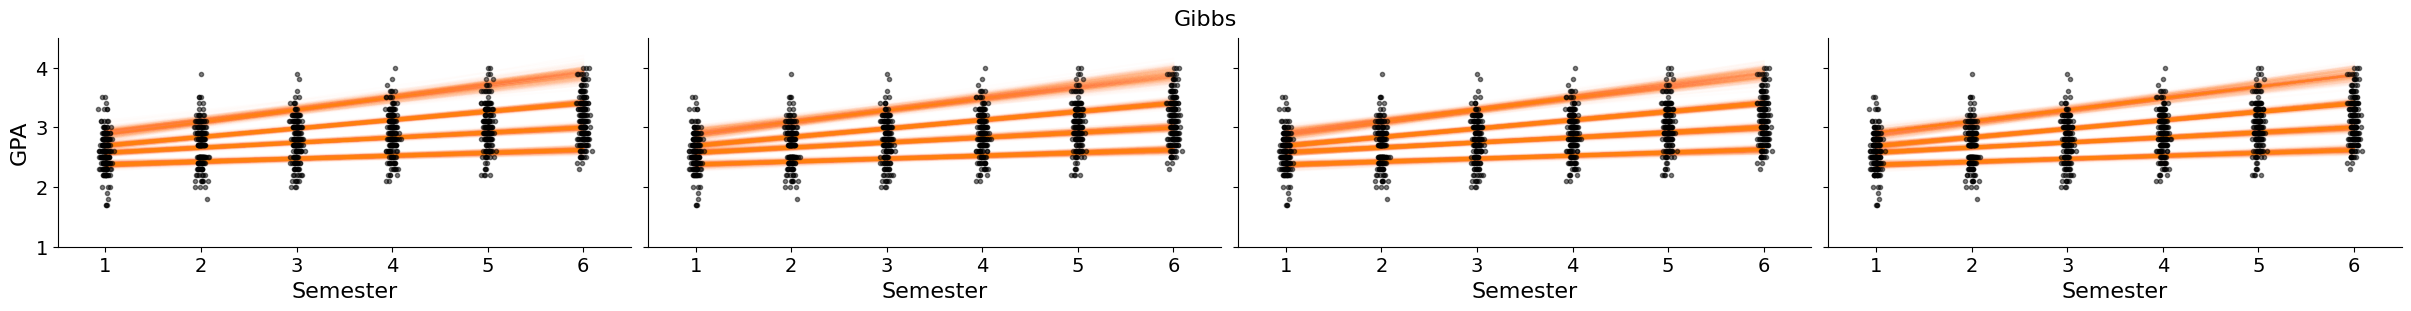

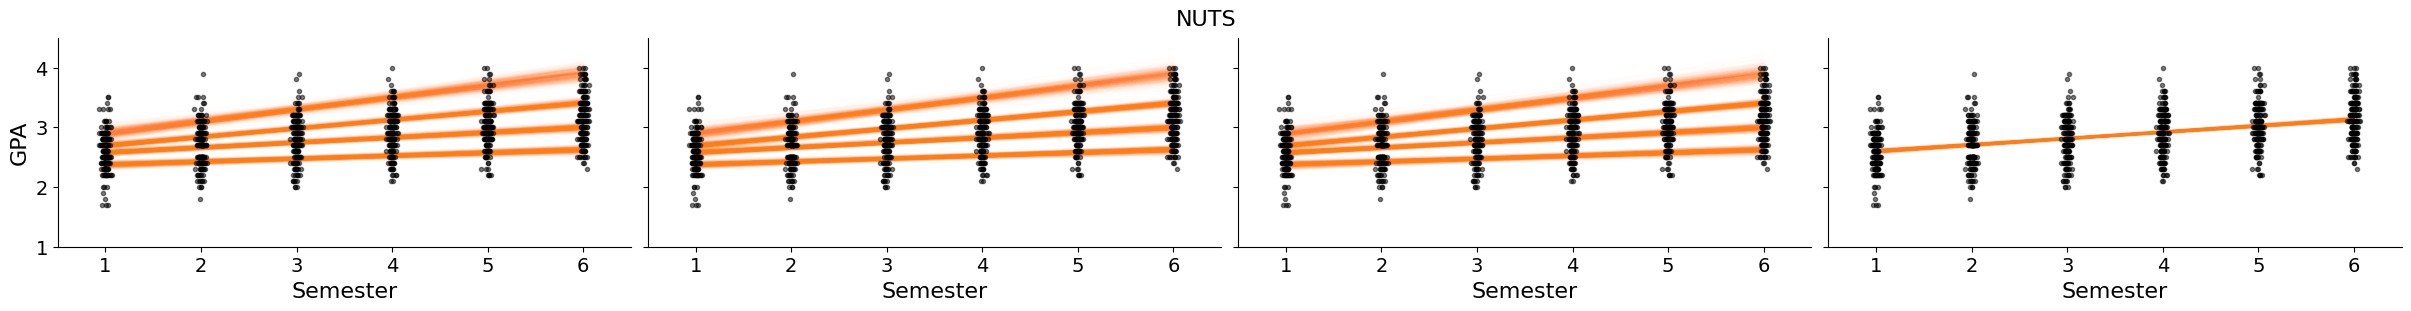

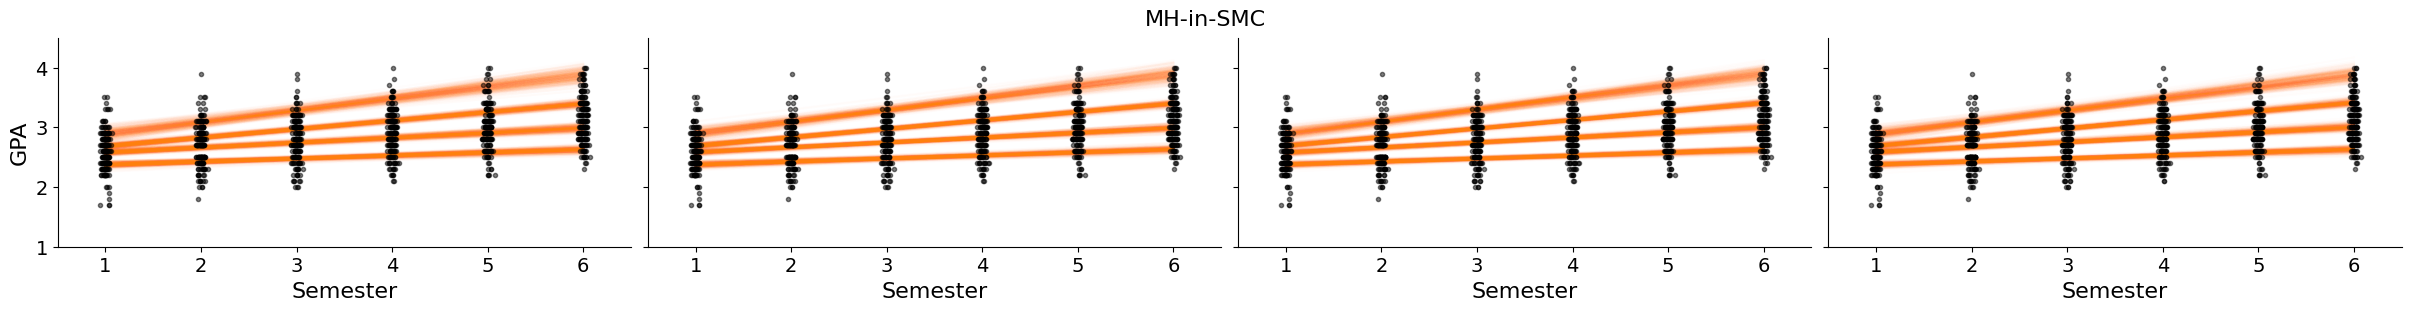

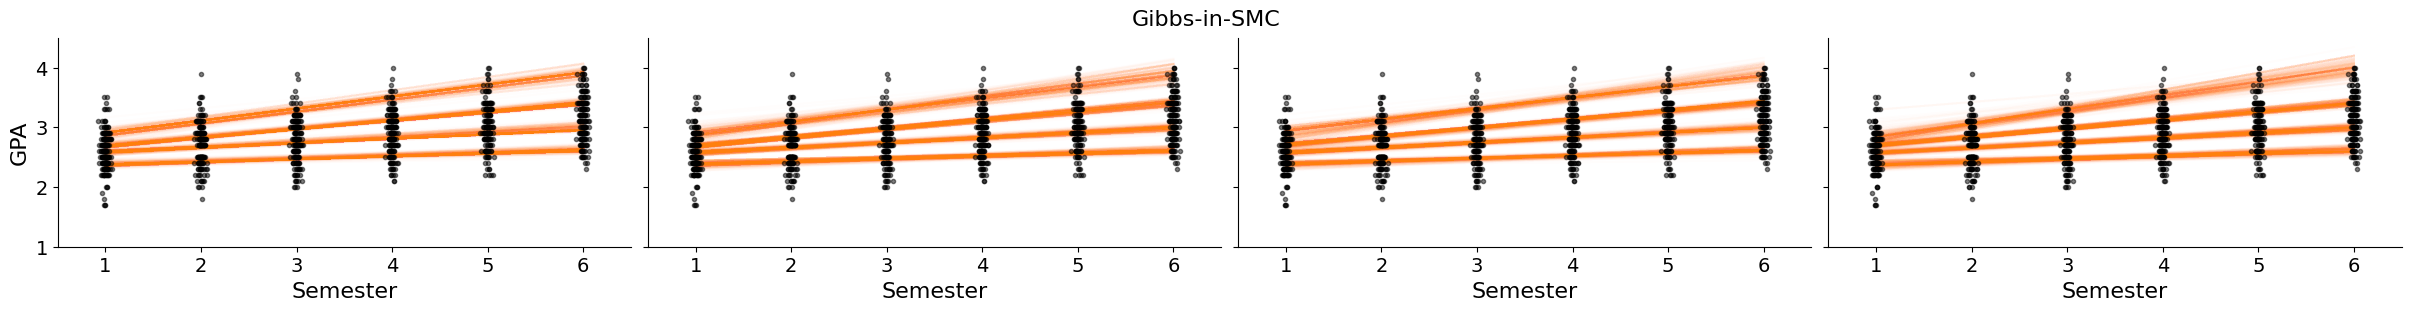

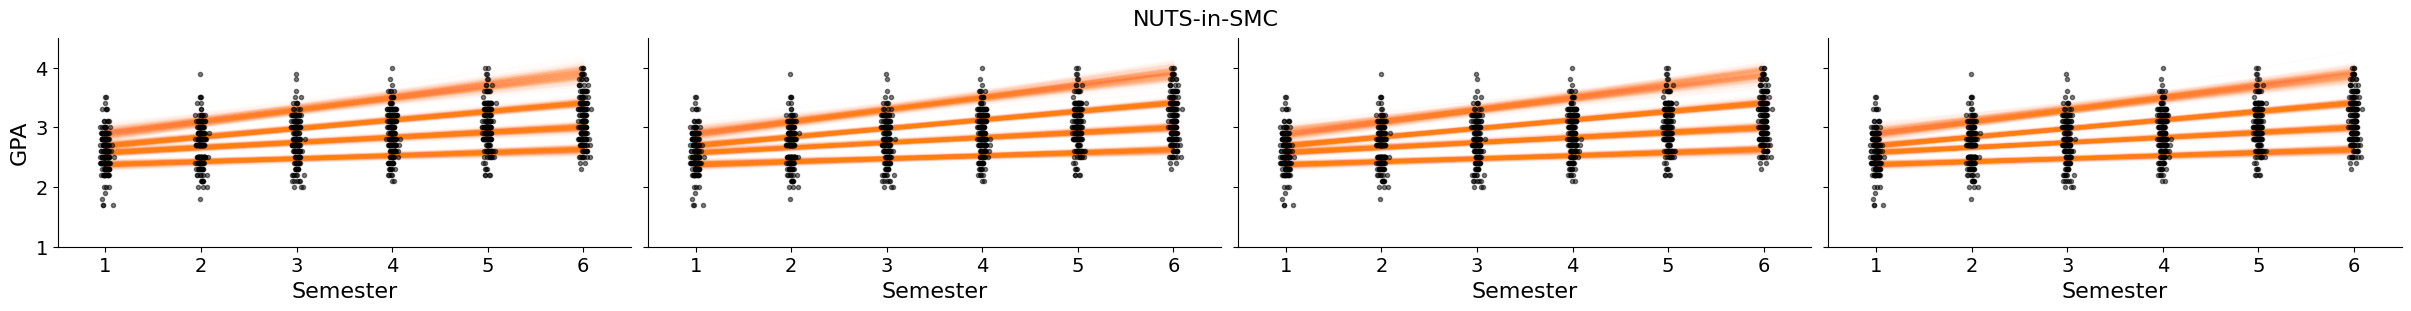

In [82]:
key = jrnd.PRNGKey(42)
for name in mcmc_results.keys():
    key, subkey = jrnd.split(key)    
    plot_fit(subkey, Y, smpls=mcmc_results[name][-1]['samples'], K=K, degree=degree, title=name)

for name in smc_results.keys():
    key, subkey = jrnd.split(key)    
    plot_fit(subkey, Y, smpls=smc_results[name][-1]['final_state'].particles, K=K, degree=degree, title=name)

Plot the marginal posteriors

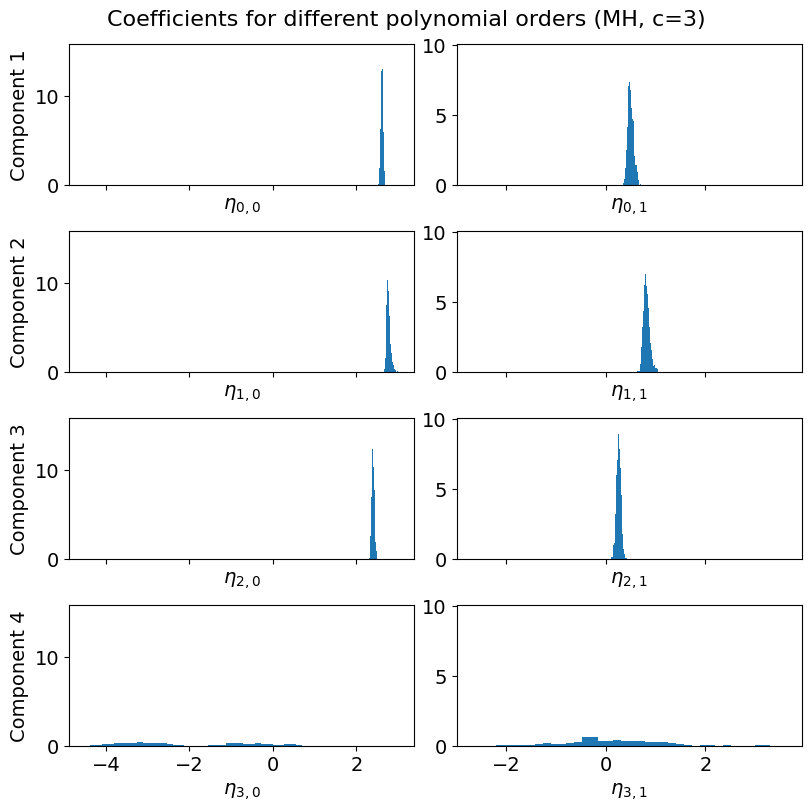

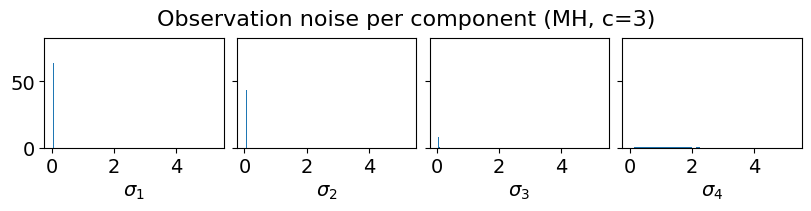

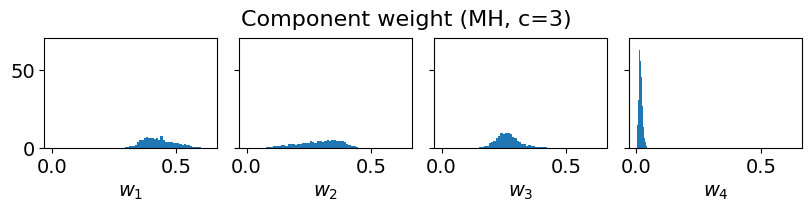

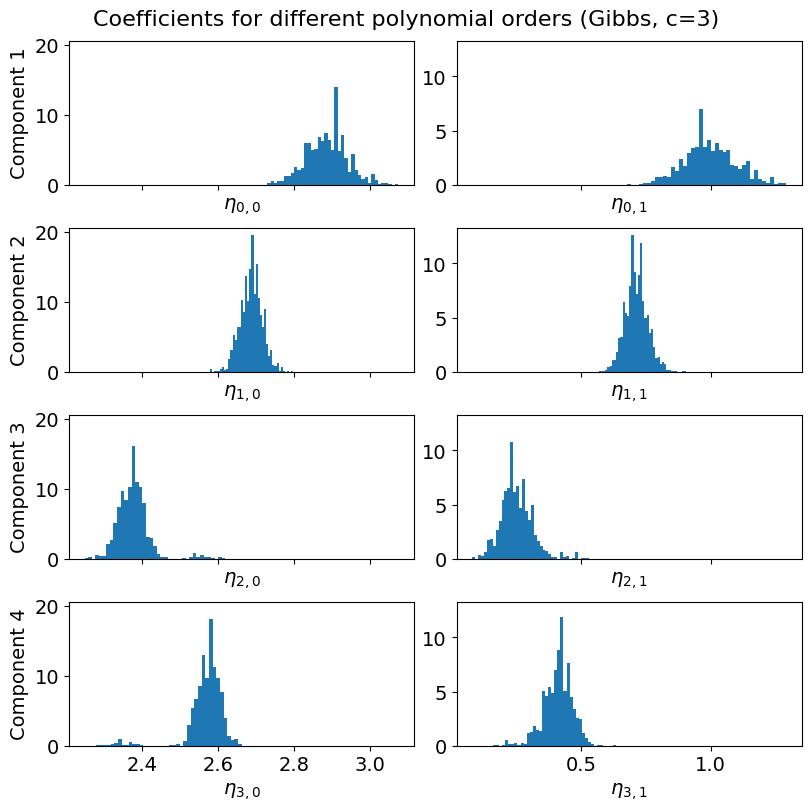

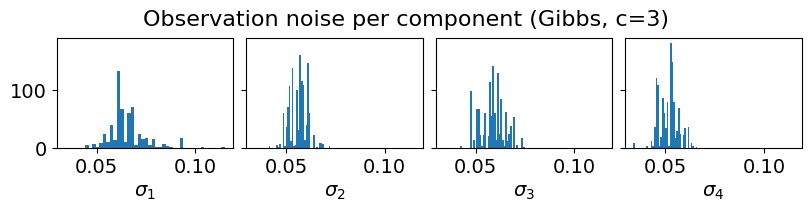

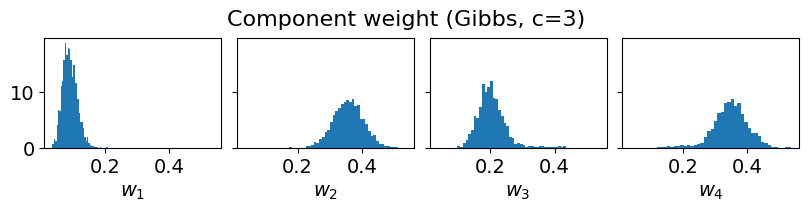

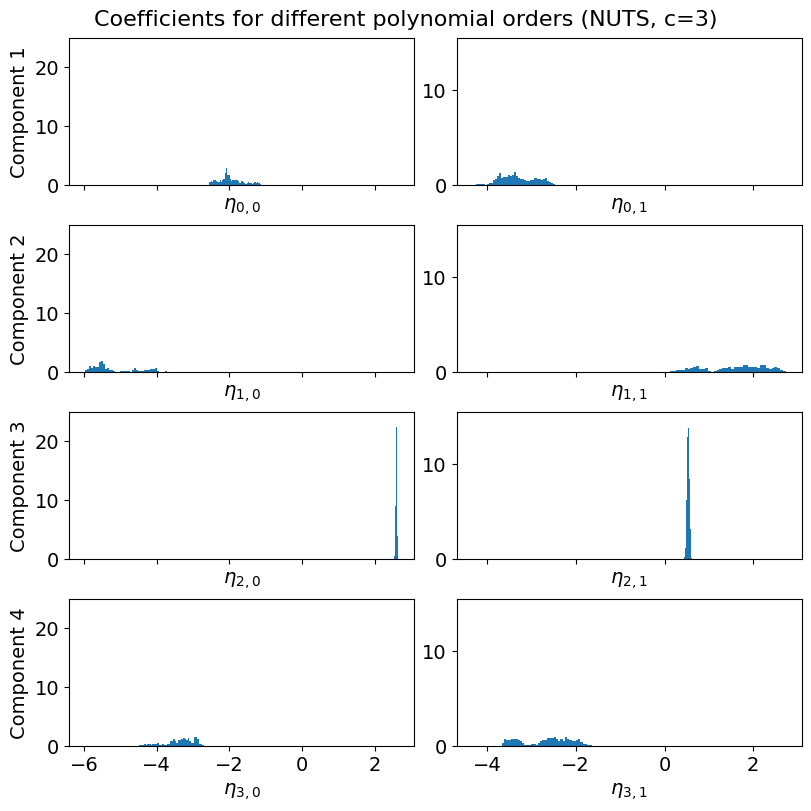

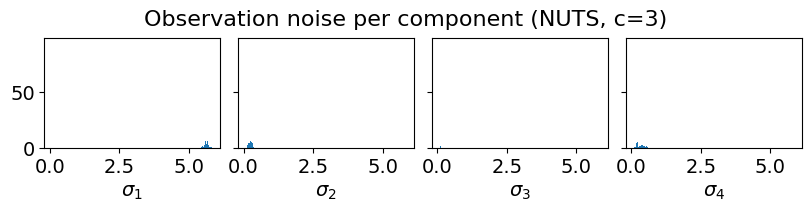

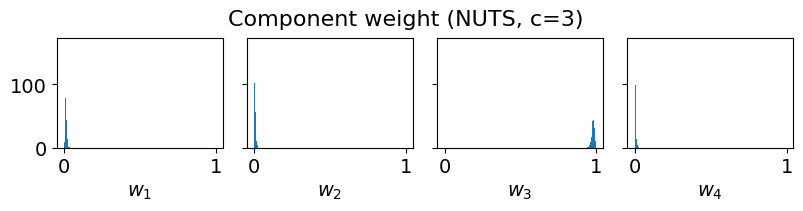

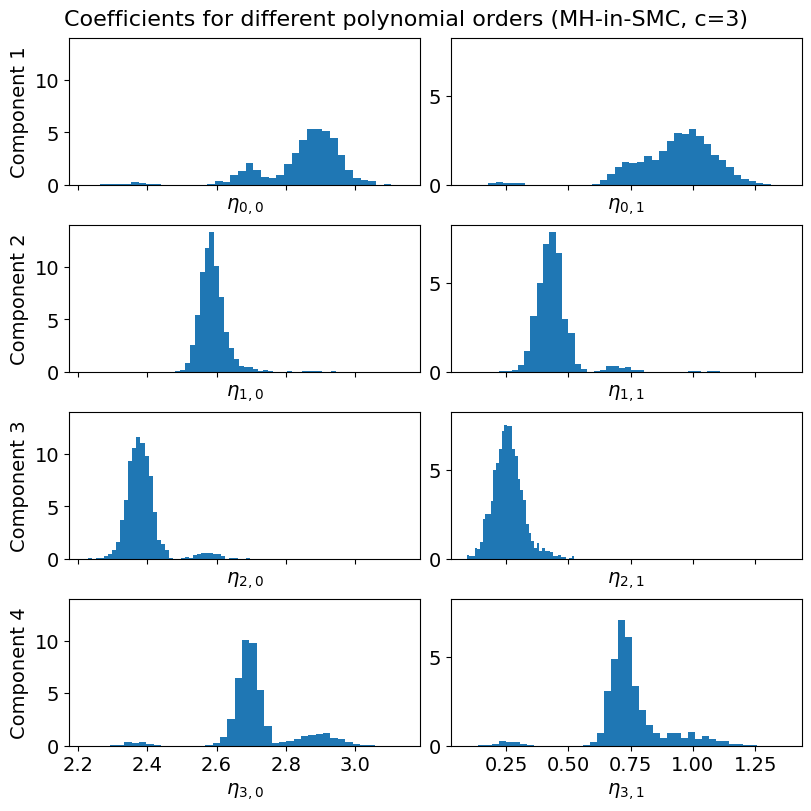

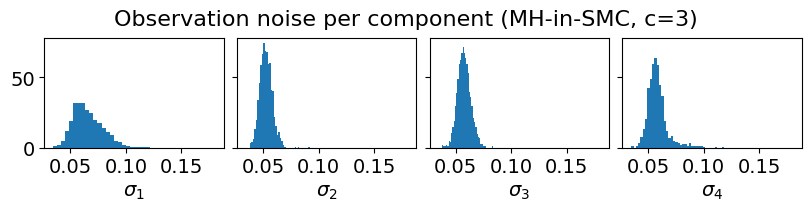

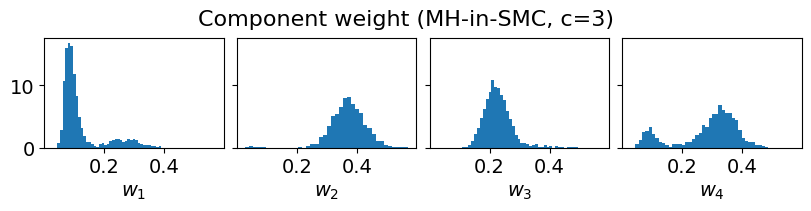

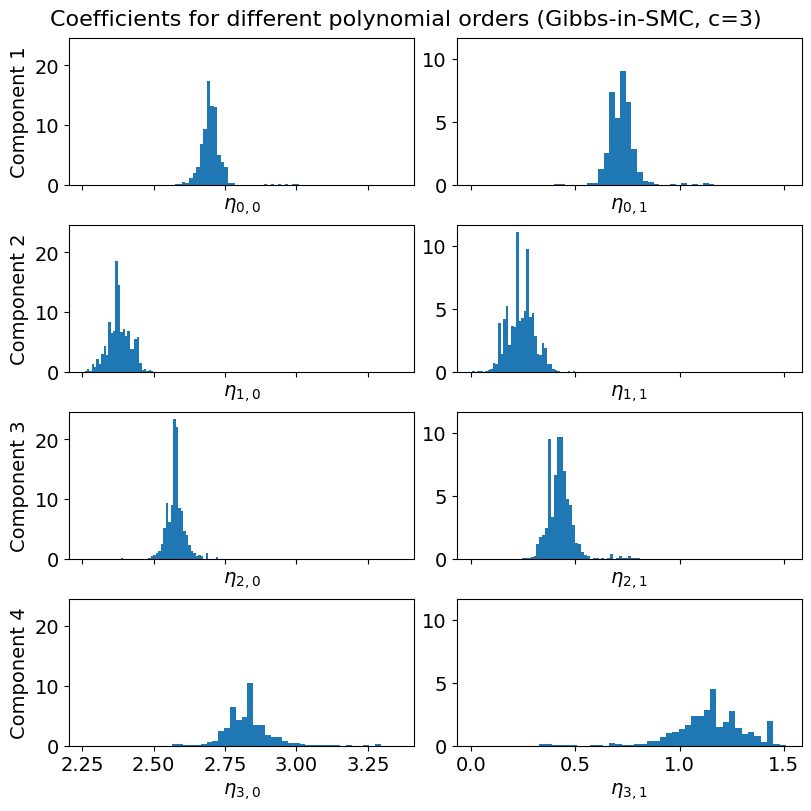

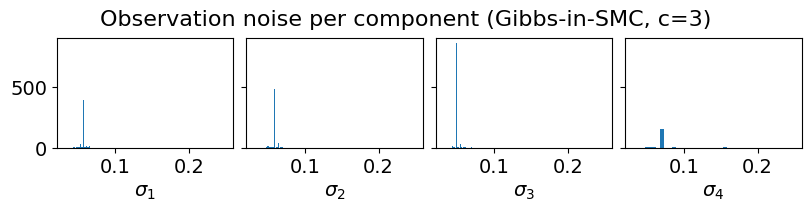

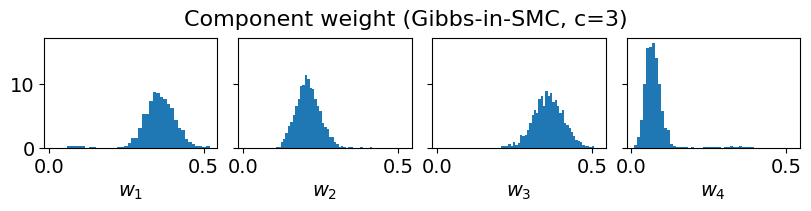

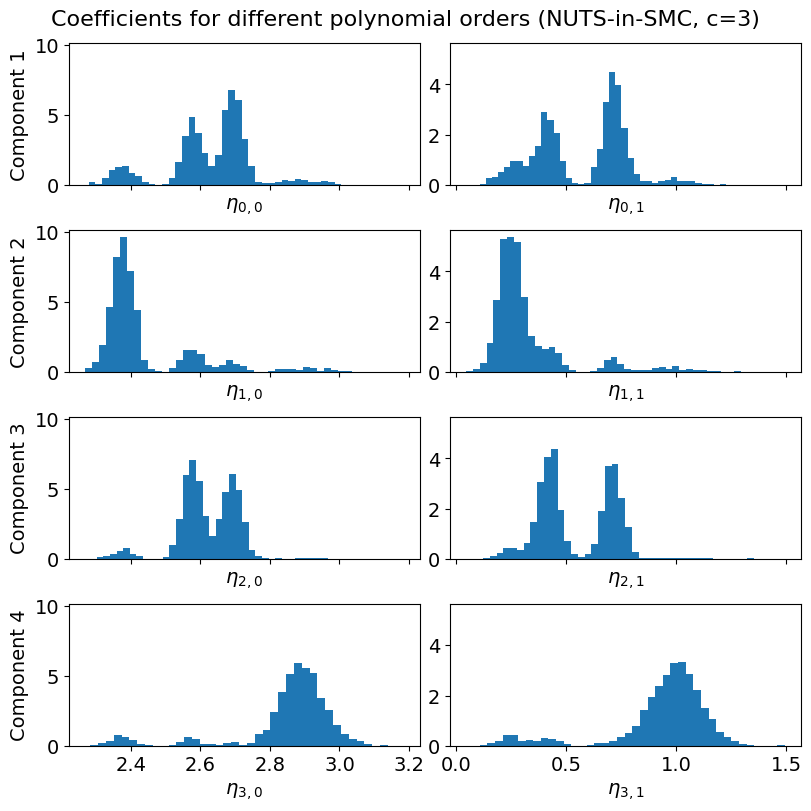

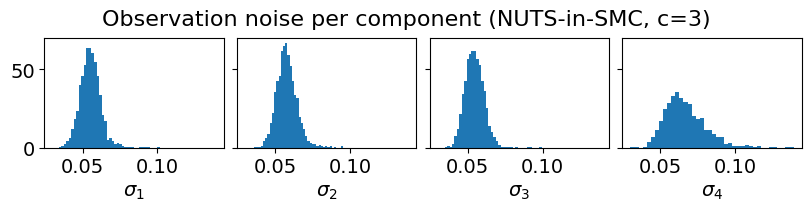

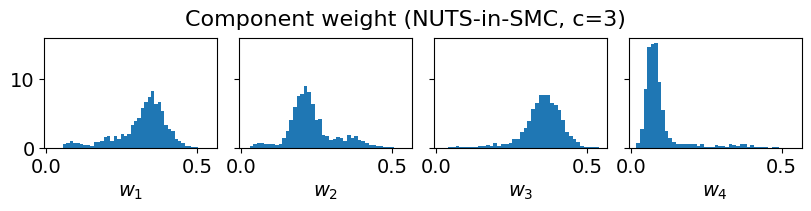

In [84]:
chain = 3

for name in mcmc_results.keys():
    selected_chain = select_chain(mcmc_results[name][-1]['samples'], chain=chain)
    plot_posterior(smpls=selected_chain, K=K, degree=degree, title=f'{name}, c={chain}')

for name in smc_results.keys():
    selected_chain = select_chain(smc_results[name][-1]['final_state'].particles, chain=chain)
    plot_posterior(smpls=selected_chain, K=K, degree=degree, title=f'{name}, c={chain}')

Construct Table 1 (forgot to save time in bamojax-numpyro implementation).

In [86]:
num_chains = 4
print(f'     Sampler &       LL         &       KL       &  ESS &     Time')


def print_results(name, results):
    scores = []
    if 'samples' in results:
        states = results['samples']
    elif 'final_state' in results:
        states = results['final_state'].particles
    fit = data_fit(GrMM, states, num_chains)
    for c in range(num_chains):
        scores.append(multimodality_kl_score(states, c))
    scores = jnp.asarray(scores)
    # timing = results['time_elapsed']
    # if name in ['nuts', 'NUTS-in-SMC']:
    #     timing += warmup_time  # this also takes time!
    ess = effective_sample_size(states['beta']).flatten().mean()
    print(f'{name:>12s} & {jnp.mean(fit):0.2f} \pm {jnp.std(fit):0.2f} & {jnp.mean(scores):0.2f} \pm {jnp.std(scores):0.2f} & {ess:0.2f} & --')


for name, value in mcmc_results.items():
    print_results(name, value[-1])

for name, value in smc_results.items():
    print_results(name, value[-1])


     Sampler &       LL         &       KL       &  ESS &     Time
          MH & -171.90 \pm 12.32 & 10.77 \pm 2.82 & 8.00 & --
       Gibbs & -156.94 \pm 0.70 & 11.52 \pm 2.22 & 2.37 & --
        NUTS & -228.30 \pm 124.36 & 10.75 \pm 4.12 & 2.19 & --
   MH-in-SMC & -157.58 \pm 0.80 & 4.79 \pm 1.63 & 2.89 & --
Gibbs-in-SMC & -158.50 \pm 0.70 & 4.64 \pm 2.28 & 3.52 & --
 NUTS-in-SMC & -157.28 \pm 0.39 & 0.90 \pm 0.34 & 8.52 & --


Todo: make master figure

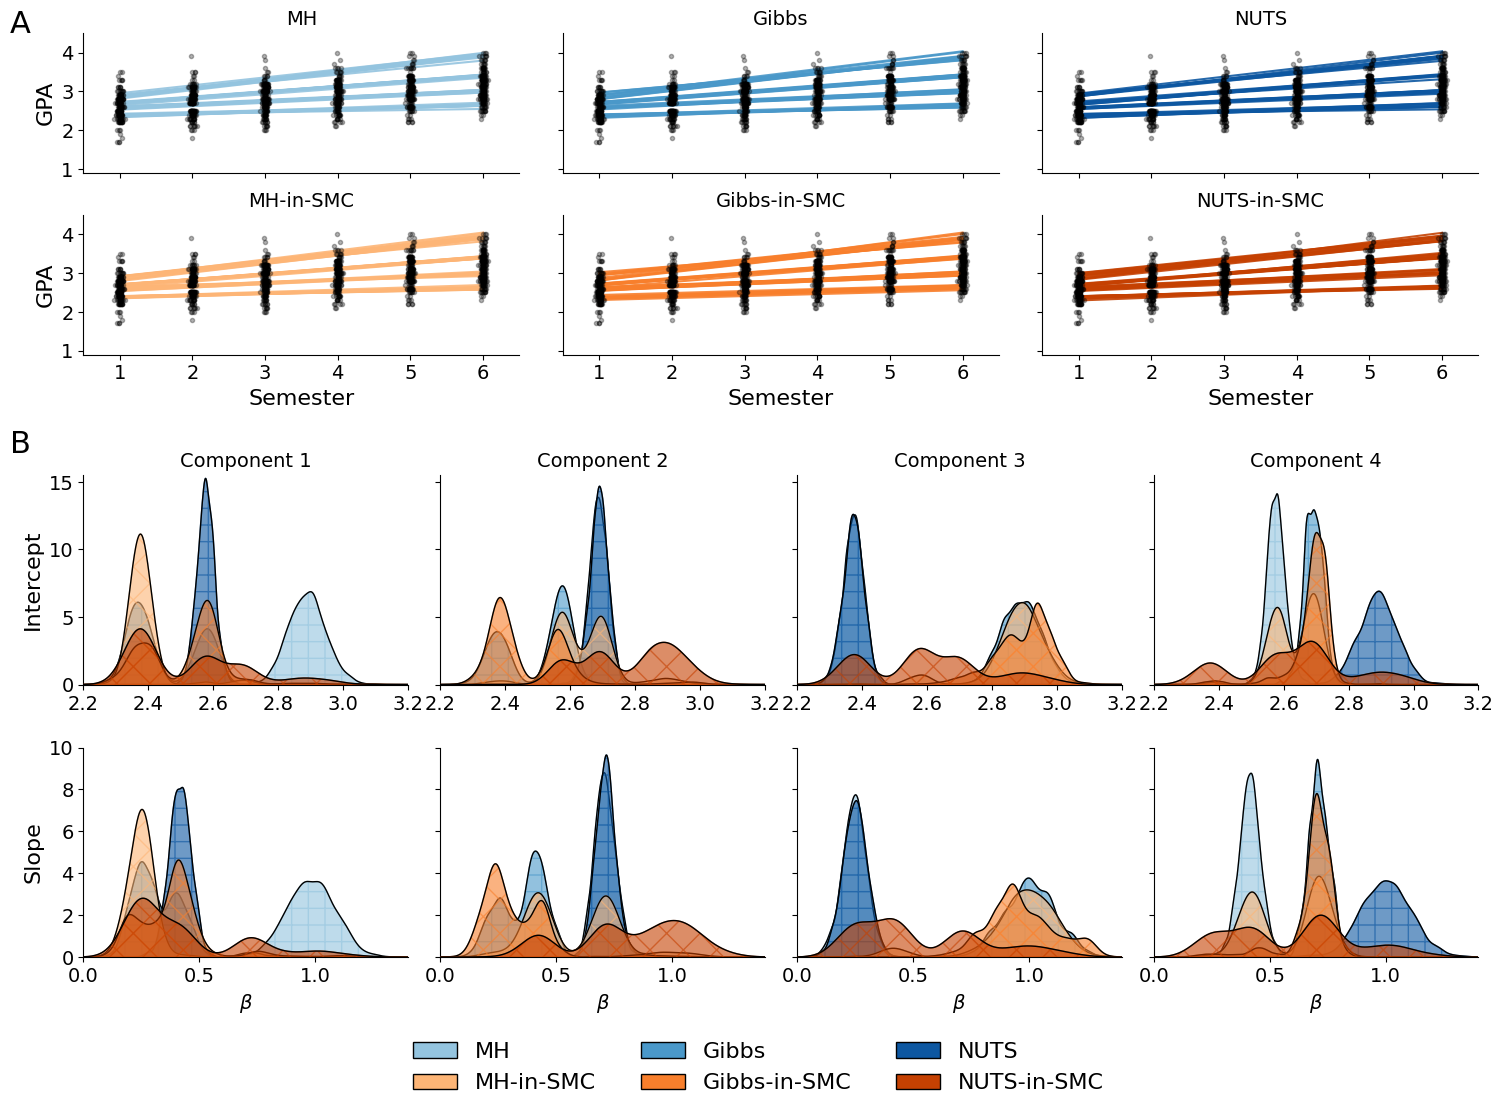

In [88]:
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

def plot_fit_method(key, Y, results_dict, chain, K, colors, axes):

    def plot_predictions(key, ax, beta_samples, color):
        for i in range(0, num_particles, 200):
            for k in range(K):
                beta = beta_samples[i, k, :]
                mu = jnp.dot(beta, X)
                ax.plot(X[1, :], mu, color=color, alpha=0.9)

        for i in range(T):            
            jitter = 0.005*jrnd.normal(key, shape=(N, ))
            ax.plot(jitter + X[1, i], Y[:, i], '.', color='k', alpha=0.3)

    #
    def decorate_axis(ax):
        ax.set_xlabel('Semester', fontsize=MEDIUM_SIZE)
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([1.0, 4.5])
        ax.set_xticks(jnp.linspace(0, 1, T), jnp.arange(T) + 1, fontsize=SMALL_SIZE)
        ax.tick_params(axis='y', labelsize=SMALL_SIZE)
    
    #
    N, T = Y.shape
    for i, (name, results) in enumerate(results_dict.items()):
        if 'samples' in results[-1]:
            plot_predictions(key, axes[i], results[-1]['samples']['beta'][chain, ...], color=colors[i])
        else:
            plot_predictions(key, axes[i], results[-1]['final_state'].particles['beta'][chain, ...], color=colors[i])
            decorate_axis(axes[i])
        axes[i].tick_params(axis='y', labelsize=SMALL_SIZE)
        axes[i].set_title(name, fontsize=SMALL_SIZE)
        for spine in ['top', 'right']:
            axes[i].spines[spine].set_visible(False)


    axes[0].set_ylabel('GPA', fontsize=MEDIUM_SIZE)

#

M = len(mcmc_results.keys())

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.5], hspace=0.3, wspace=0.0)

gs_inference = gs[0].subgridspec(2, M)
gs_coef = gs[1].subgridspec(2, K)

axes_inference = gs_inference.subplots(sharex=True, sharey=True)
axes_coef = gs_coef.subplots(sharex='row', sharey='row')

chain = 2

colors1 = plt.get_cmap('Blues')([0.4, 0.6, 0.85])
colors2 = plt.get_cmap('Oranges')([0.35, 0.55, 0.8])
colors = np.vstack((colors1, colors2))

plot_fit_method(key, Y, mcmc_results, chain=chain, K=K, colors=colors1, axes=axes_inference[0, :])
plot_fit_method(key, Y, smc_results, chain=chain, K=K, colors=colors2, axes=axes_inference[1, :])

for ax in axes_inference.flatten():
    ax.set_ylim([0.9, 4.5])
    ax.set_yticks(jnp.arange(1, 5))
    ax.set_yticklabels(jnp.arange(1, 5))


param_ranges = {0:jnp.linspace(2.2, 3.2, num=1000), 
                1: jnp.linspace(0.0, 1.4, num=1000)}

ylims = [15.5, 10]

output = [mcmc_results['MH'][-1]['samples'], mcmc_results['Gibbs'][-1]['samples'], mcmc_results['NUTS'][-1]['samples'],
          smc_results['MH-in-SMC'][-1]['final_state'].particles, smc_results['Gibbs-in-SMC'][-1]['final_state'].particles, smc_results['NUTS-in-SMC'][-1]['final_state'].particles]

methodlabels = ['MH', 'Gibbs', 'NUTS', 'MH-in-SMC', 'Gibbs-in-SMC', 'NUTS-in-SMC']
hatches = ['+', '+', '+', 'x', 'x', 'x']

for d in [0, 1]:
    param_range = param_ranges[d]      
    for k in range(K):
        ax = axes_coef[d, k]    
        for m in range(len(methodlabels)):  
            samples = output[m]
            pdf = gaussian_kde(samples['beta'][chain, :, k, d].flatten())
            y = pdf(param_range)
            ax.plot(param_range, y, color='k', lw=1, zorder=m+0.5)
            ax.fill_between(param_range, y, jnp.zeros_like(y), color=colors[m], alpha=0.6, zorder=m, label=methodlabels[m], hatch=hatches[m])
            ax.tick_params(axis='both', labelsize=SMALL_SIZE)
            ax.set_xlim([param_range[0], param_range[-1]])
            ax.set_ylim(bottom=0, top=ylims[d])
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)       

for k in range(K):
    axes_coef[0, k].set_title(f'Component {k+1}', fontsize=SMALL_SIZE)
    axes_coef[1, k].set_xlabel(r'$\beta$', fontsize=SMALL_SIZE)
        
axes_coef[0, 0].set_ylabel('Intercept', fontsize=MEDIUM_SIZE)
axes_coef[1, 0].set_ylabel('Slope', fontsize=MEDIUM_SIZE);

plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.figtext(0.09, 0.88, 'A', size=LARGE_SIZE, ha='center', transform=plt.gcf().transFigure)
plt.figtext(0.09, 0.53, 'B', size=LARGE_SIZE, ha='center', transform=plt.gcf().transFigure)

handles, labels = axes_coef[1, 0].get_legend_handles_labels()
handles = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors, labels)]
order = [0, 3, 1, 4, 2, 5]
fig.legend([handles[ix] for ix in order], [labels[ix] for ix in order], loc='lower center', ncols=M, frameon=False, 
           bbox_to_anchor=(0, -0.02, 1, 1), bbox_transform=plt.gcf().transFigure, fontsize=MEDIUM_SIZE);

plt.savefig(f'/home/maxhin/Documents/Code/SMC tutorial/Review1 results/grmm_combined_figure.pdf', 
            bbox_inches='tight', pad_inches=0.0)


Clearly, the SMC-based methods capture the multimodality much better. Within these methods, Gibbs and NUTS seem comparable in performance, but Gibbs is way faster and therefore preferred. The additional computation required for NUTS is not needed when incorporating these mutations into the SMC routine.